In [ ]:
"""
CELL 1 — SETUP
Purpose:
Import libraries, create outputs folder, and define constants.
"""

import os
import warnings
warnings.filterwarnings("ignore")

# Create folders
os.makedirs("outputs", exist_ok=True)

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

sns.set(style="whitegrid")

# Constants
CARBON_INTENSITY_KG_PER_KWH = 0.45
ANOMALY_Z_THRESHOLD = 2.5


warnings.filterwarnings("ignore")

print("✅ Setup complete.")


✅ Setup complete.


In [5]:
"""
CELL 2 — FETCH THE HOUSEHOLD ELECTRICITY DATASET
Purpose:
- Load the 'Individual household electric power consumption' dataset directly from UCI.
- This avoids version mismatches in ucimlrepo==0.0.7.
"""

url = "https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip"


df_raw = pd.read_csv(
    url,
    sep=';',
    low_memory=False
)

print("✅ Dataset loaded successfully from UCI!")
print("Shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())
df_raw.head()


✅ Dataset loaded successfully from UCI!
Shape: (2075259, 9)
Columns: ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [12]:
print("Columns in df_raw:")
print(df_raw.columns.tolist())

Columns in df_raw:
['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


In [6]:
"""
CELL 3 — DATA CLEANING
Purpose:
- Combine 'Date' and 'Time' into 'DateTime'
- Handle '?' missing values
- Convert numeric columns
"""

df = df_raw.copy()

# Combine date and time
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce', dayfirst=True)

# Drop old columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Convert numeric columns
num_cols = df.columns
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop missing
df.dropna(inplace=True)

# Set datetime index
df.set_index('DateTime', inplace=True)
df.sort_index(inplace=True)

print("✅ Cleaned dataset with", len(df), "rows")
df.head()


✅ Cleaned dataset with 2049280 rows


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
1166289840000000000,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1166289900000000000,5.360,0.436,233.63,23.0,0.0,1.0,16.0
1166289960000000000,5.374,0.498,233.29,23.0,0.0,2.0,17.0
1166290020000000000,5.388,0.502,233.74,23.0,0.0,1.0,17.0
1166290080000000000,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [8]:
df.index = pd.to_datetime(df.index, errors='coerce')

In [9]:
"""
CELL 4 — FEATURE ENGINEERING (fixed)
Purpose:
Ensure datetime index is correct, then add temporal columns and calculate energy consumption per minute.
"""

# Ensure index is datetime
df.index = pd.to_datetime(df.index, errors='coerce')

# Remove any invalid dates (NaT)
df = df[~df.index.isna()]

# Add temporal columns
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

# Convert active power (kW) to energy (kWh) per minute
df['energy_kwh'] = df['Global_active_power'] / 60.0

print("✅ Feature engineering done successfully.")
print("Index type:", type(df.index))
df.head()


✅ Feature engineering done successfully.
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,year,month,day,hour,dayofweek,energy_kwh
DateTime,,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006,12,16,17,5,0.070267
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006,12,16,17,5,0.089333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006,12,16,17,5,0.089567
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006,12,16,17,5,0.089800
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006,12,16,17,5,0.061100


In [10]:
"""
CELL 5 — AGGREGATE ENERGY DATA
Purpose:
Aggregate 1-minute energy data to daily and hourly totals.
"""

# Daily
daily_df = df['energy_kwh'].resample('D').sum().to_frame('daily_kwh')

# Hourly
hourly_df = df['energy_kwh'].resample('H').sum().to_frame('hourly_kwh')

print("✅ Aggregations complete.")
display(daily_df.head())


✅ Aggregations complete.


,daily_kwh
DateTime,
2006-12-16,20.152933
2006-12-17,56.507667
2006-12-18,36.730433
2006-12-19,27.769900
2006-12-20,37.095800


In [11]:
"""
CELL 6 — CARBON FOOTPRINT
Purpose:
Estimate CO2 emissions using carbon intensity factor.
"""

daily_df['daily_kgco2'] = daily_df['daily_kwh'] * CARBON_INTENSITY_KG_PER_KWH
hourly_df['hourly_kgco2'] = hourly_df['hourly_kwh'] * CARBON_INTENSITY_KG_PER_KWH

print("✅ Carbon footprint calculated.")
daily_df.head()


✅ Carbon footprint calculated.


,daily_kwh,daily_kgco2
DateTime,,
2006-12-16,20.152933,9.068820
2006-12-17,56.507667,25.428450
2006-12-18,36.730433,16.528695
2006-12-19,27.769900,12.496455
2006-12-20,37.095800,16.693110


In [12]:
"""
CELL 7 — KPI CALCULATIONS
Purpose:
Compute total energy, emissions, average daily use, and peak day.
"""

total_energy = daily_df['daily_kwh'].sum()
total_emission = daily_df['daily_kgco2'].sum()
avg_daily = daily_df['daily_kwh'].mean()
peak_day = daily_df['daily_kwh'].idxmax()
peak_value = daily_df['daily_kwh'].max()

kpi = {
    'Total Energy (kWh)': total_energy,
    'Total Emissions (kgCO2)': total_emission,
    'Average Daily Energy (kWh)': avg_daily,
    'Peak Day': str(peak_day.date()),
    'Peak Day Energy (kWh)': peak_value
}

kpi_df = pd.DataFrame([kpi])
kpi_df.to_csv('outputs/kpi_summary.csv', index=False)
print("✅ KPI Summary:")
display(kpi_df)


✅ KPI Summary:


,Total Energy (kWh),Total Emissions (kgCO2),Average Daily Energy (kWh),Peak Day,Peak Day Energy (kWh)
0,37283.7477,16777.686465,25.855581,2006-12-23,79.556433


In [13]:
"""
CELL 8 — ANOMALY DETECTION
Purpose:
Identify unusually high or low consumption days.
"""

daily_df['z_score'] = stats.zscore(daily_df['daily_kwh'])
daily_df['is_anomaly'] = (daily_df['z_score'].abs() > ANOMALY_Z_THRESHOLD).astype(int)
anomalies = daily_df[daily_df['is_anomaly'] == 1]

print(f"✅ Found {len(anomalies)} anomaly days.")
anomalies.to_csv('outputs/anomaly_days.csv')
anomalies.head()


✅ Found 37 anomaly days.


,daily_kwh,daily_kgco2,z_score,is_anomaly
DateTime,,,,
2006-12-17,56.507667,25.428450,2.980353,1
2006-12-23,79.556433,35.800395,5.221422,1
2006-12-26,65.568500,29.505825,3.861353,1
2006-12-29,52.906533,23.807940,2.630209,1
2006-12-31,58.236600,26.206470,3.148460,1


In [33]:
"""
🌿 FINAL VISUALIZATION SECTION — SUSTAINABILITY ENERGY ANALYTICS
Purpose:
Generate rich visual insights:
1️⃣ Hourly Energy Usage Pattern
2️⃣ Daily Energy Distribution
3️⃣ Daily Trend + 7-Day Rolling Average
4️⃣ Correlation Heatmap
"""

'\n🌿 FINAL VISUALIZATION SECTION — SUSTAINABILITY ENERGY ANALYTICS\nPurpose:\nGenerate rich visual insights:\n1️⃣ Hourly Energy Usage Pattern\n2️⃣ Daily Energy Distribution\n3️⃣ Daily Trend + 7-Day Rolling Average\n4️⃣ Correlation Heatmap\n'

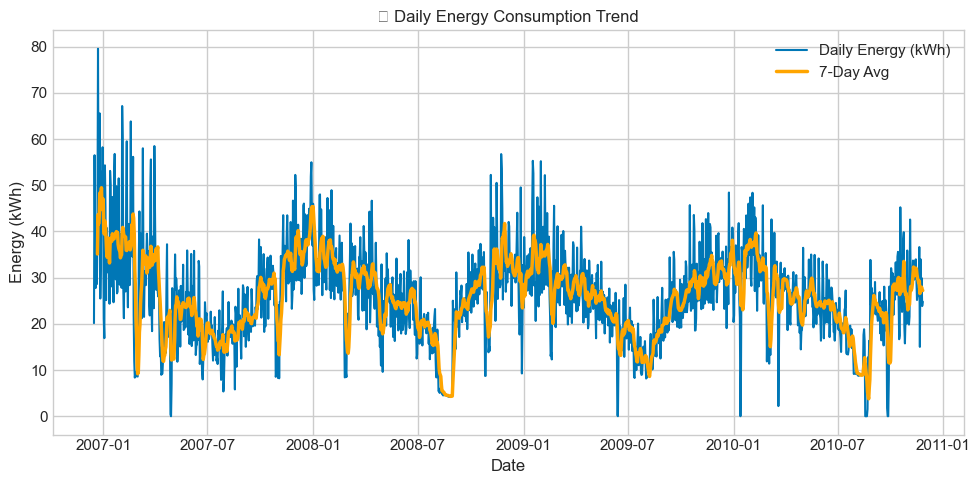

In [43]:
"""
✅ FINAL VISUALIZATION SECTION — CLEAN & EASY RESULTS
Generates:
1️⃣ Daily Energy Trend
2️⃣ Hourly Energy Pattern
3️⃣ Daily Energy Distribution
4️⃣ Correlation Heatmap
5️⃣ Simple Insights
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Basic Styling ===
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
sns.set_palette("muted")

# Ensure proper datetime index
daily_df.index = pd.to_datetime(daily_df.index, errors="coerce")
hourly_df.index = pd.to_datetime(hourly_df.index, errors="coerce")

# =====================================================================
# 1️⃣ DAILY ENERGY TREND
# =====================================================================

daily_df["rolling_7d"] = daily_df["daily_kwh"].rolling(7).mean()

plt.figure()
plt.plot(daily_df.index, daily_df["daily_kwh"], label="Daily Energy (kWh)", color="#0077b6")
plt.plot(daily_df.index, daily_df["rolling_7d"], color="orange", linewidth=2.5, label="7-Day Avg")
plt.title("📈 Daily Energy Consumption Trend")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.tight_layout()
plt.show()


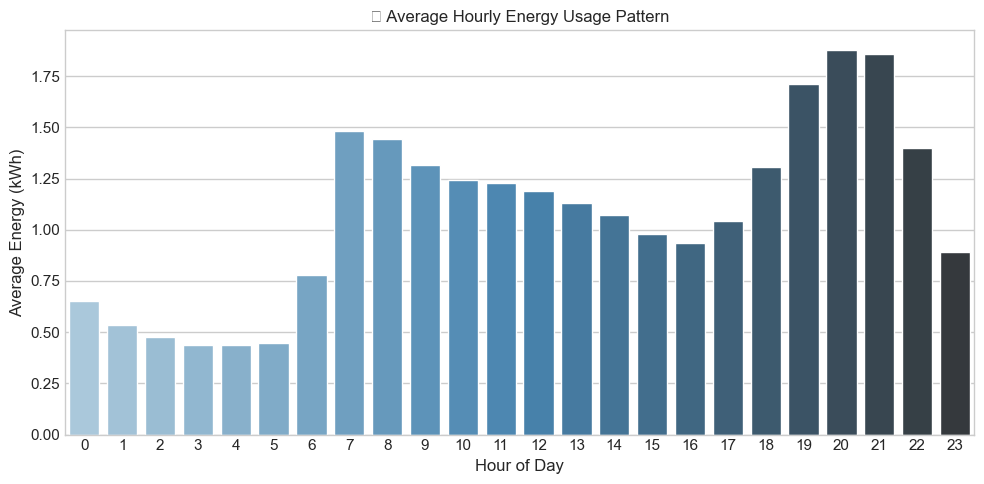

In [44]:
# =====================================================================
# 2️⃣ HOURLY ENERGY USAGE PATTERN
# =====================================================================

hourly_pattern = (
    hourly_df.groupby(hourly_df.index.hour)["hourly_kwh"]
    .mean()
    .reset_index()
)
hourly_pattern.columns = ["Hour", "Average_Hourly_kWh"]

plt.figure()
sns.barplot(data=hourly_pattern, x="Hour", y="Average_Hourly_kWh", palette="Blues_d")
plt.title("⏰ Average Hourly Energy Usage Pattern")
plt.xlabel("Hour of Day")
plt.ylabel("Average Energy (kWh)")
plt.tight_layout()
plt.show()

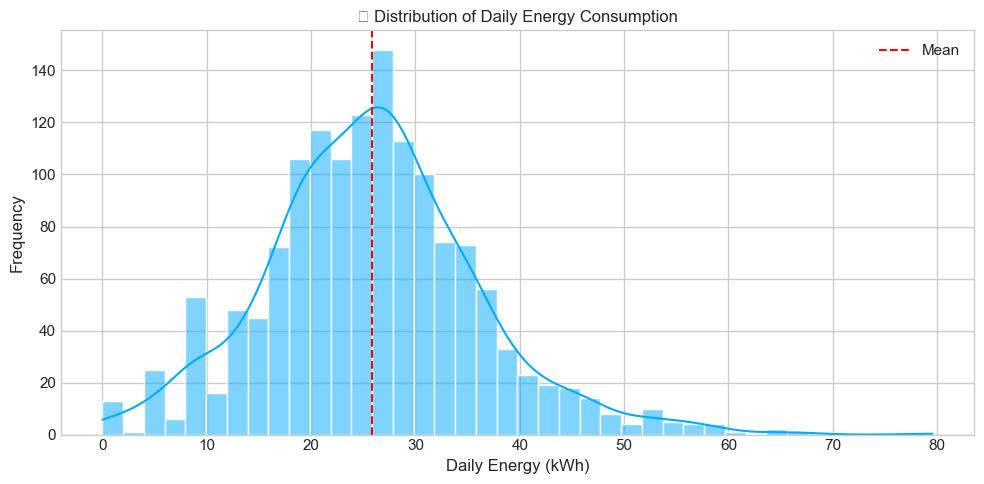

In [45]:
# =====================================================================
# 3️⃣ DISTRIBUTION OF DAILY ENERGY
# =====================================================================

plt.figure()
sns.histplot(daily_df["daily_kwh"], bins=40, kde=True, color="#00aaff")
plt.axvline(daily_df["daily_kwh"].mean(), color="red", linestyle="--", label="Mean")
plt.title("⚡ Distribution of Daily Energy Consumption")
plt.xlabel("Daily Energy (kWh)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

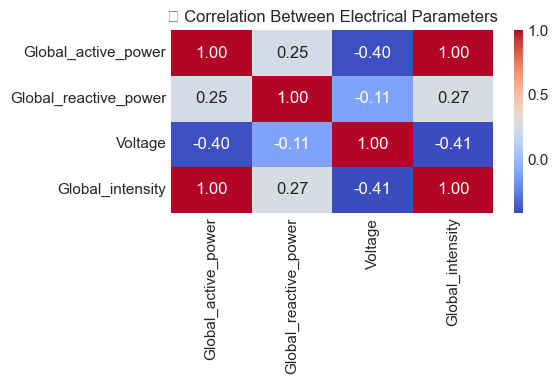

In [46]:
# =====================================================================
# 4️⃣ CORRELATION HEATMAP (POWER METRICS)
# =====================================================================

plt.figure(figsize=(6, 4))
corr = df[["Global_active_power", "Global_reactive_power", "Voltage", "Global_intensity"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("🔍 Correlation Between Electrical Parameters")
plt.tight_layout()
plt.show()

In [47]:
# =====================================================================
# 5️⃣ SIMPLE INSIGHTS
# =====================================================================

print("📊 SIMPLE INSIGHTS SUMMARY")
print("-" * 60)
print(f"Average daily energy consumption: {daily_df['daily_kwh'].mean():.2f} kWh")
print(f"Maximum daily energy usage: {daily_df['daily_kwh'].max():.2f} kWh on {daily_df['daily_kwh'].idxmax().date()}")
print(f"Minimum daily energy usage: {daily_df['daily_kwh'].min():.2f} kWh on {daily_df['daily_kwh'].idxmin().date()}")
print(f"Peak average hourly usage: {hourly_pattern['Average_Hourly_kWh'].max():.2f} kWh at {int(hourly_pattern.loc[hourly_pattern['Average_Hourly_kWh'].idxmax(), 'Hour'])}:00 hrs")
print("-" * 60)
print("✅ Visualizations & insights generated successfully!")

📊 SIMPLE INSIGHTS SUMMARY
------------------------------------------------------------
Average daily energy consumption: 25.86 kWh
Maximum daily energy usage: 79.56 kWh on 2006-12-23
Minimum daily energy usage: 0.00 kWh on 2007-04-29
Peak average hourly usage: 1.88 kWh at 20:00 hrs
------------------------------------------------------------
✅ Visualizations & insights generated successfully!


In [48]:
"""
STEP 1 — GENERATE KPI REPORT
Purpose:
- Summarize key metrics for presentation or dashboard
"""

# KPI Calculations
total_energy = daily_df['daily_kwh'].sum()
avg_daily = daily_df['daily_kwh'].mean()
max_daily = daily_df['daily_kwh'].max()
min_daily = daily_df['daily_kwh'].min()
peak_day = daily_df['daily_kwh'].idxmax()
low_day = daily_df['daily_kwh'].idxmin()

# Carbon footprint estimation
CARBON_INTENSITY_KG_PER_KWH = 0.45
total_co2 = total_energy * CARBON_INTENSITY_KG_PER_KWH

# Create summary dataframe
kpi_summary = pd.DataFrame({
    "Metric": [
        "Total Energy Consumption (kWh)",
        "Average Daily Energy (kWh)",
        "Maximum Daily Energy (kWh)",
        "Minimum Daily Energy (kWh)",
        "Peak Energy Day",
        "Lowest Energy Day",
        "Estimated Total CO₂ Emission (kg)"
    ],
    "Value": [
        f"{total_energy:,.2f}",
        f"{avg_daily:,.2f}",
        f"{max_daily:,.2f}",
        f"{min_daily:,.2f}",
        str(peak_day.date()),
        str(low_day.date()),
        f"{total_co2:,.2f}"
    ]
})

# Save KPI Summary
kpi_summary.to_csv("outputs/final_kpi_summary.csv", index=False)
display(kpi_summary)
print("✅ KPI summary report generated and saved to 'outputs/final_kpi_summary.csv'")


,Metric,Value
0,Total Energy Consumption (kWh),"37,283.75"
1,Average Daily Energy (kWh),25.86
2,Maximum Daily Energy (kWh),79.56
3,Minimum Daily Energy (kWh),0.00
4,Peak Energy Day,2006-12-23
5,Lowest Energy Day,2007-04-29
6,Estimated Total CO₂ Emission (kg),"16,777.69"


✅ KPI summary report generated and saved to 'outputs/final_kpi_summary.csv'


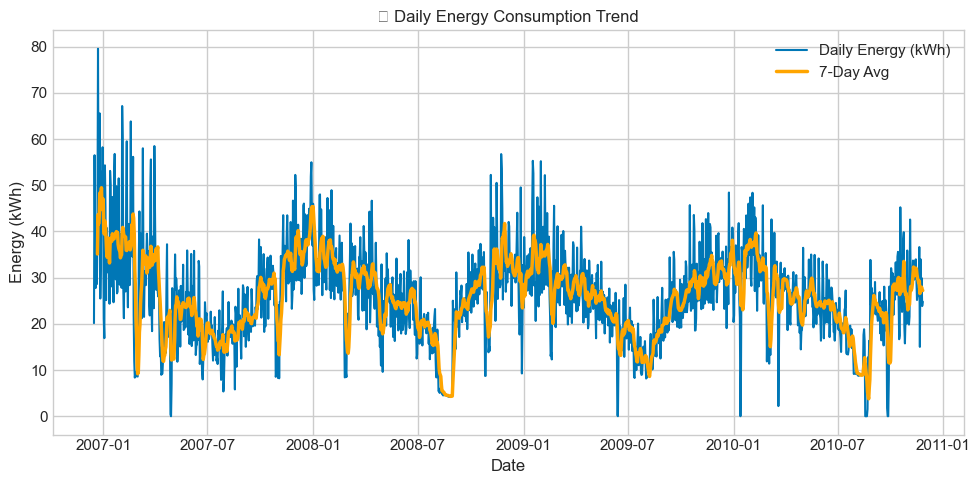

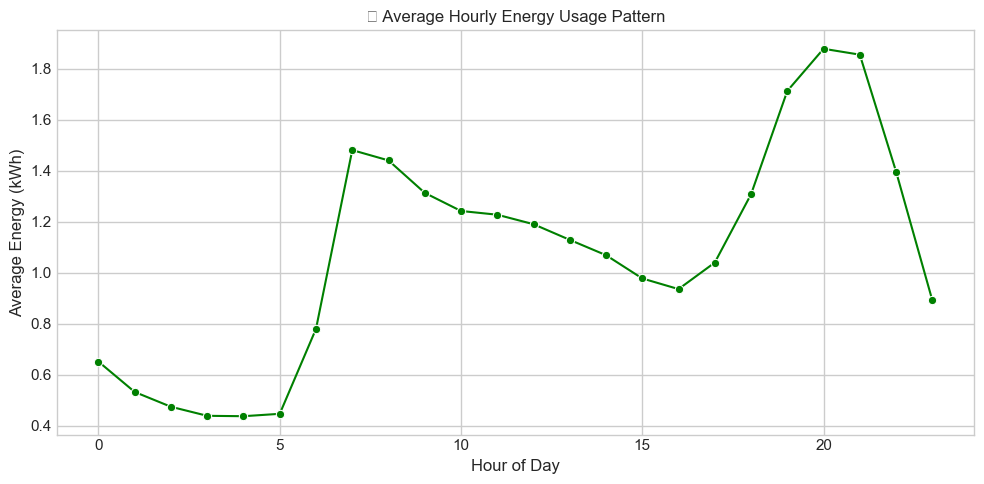

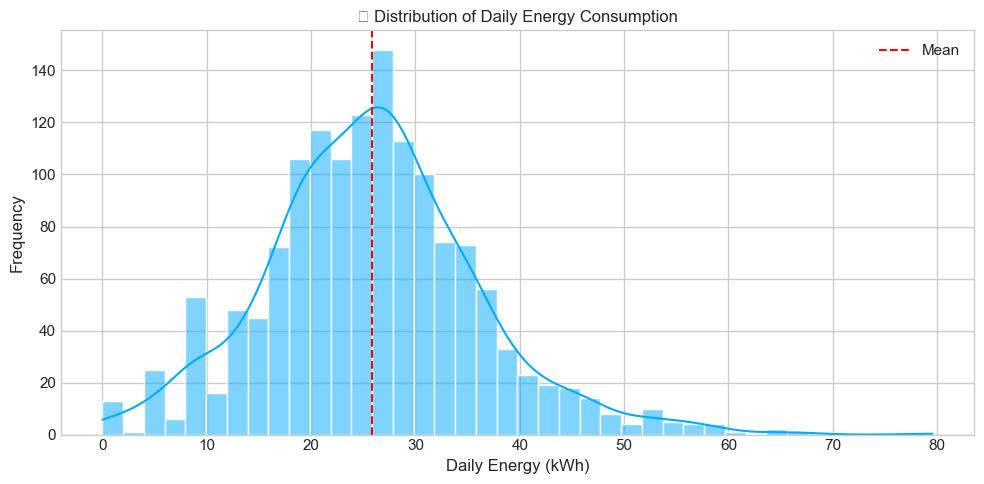

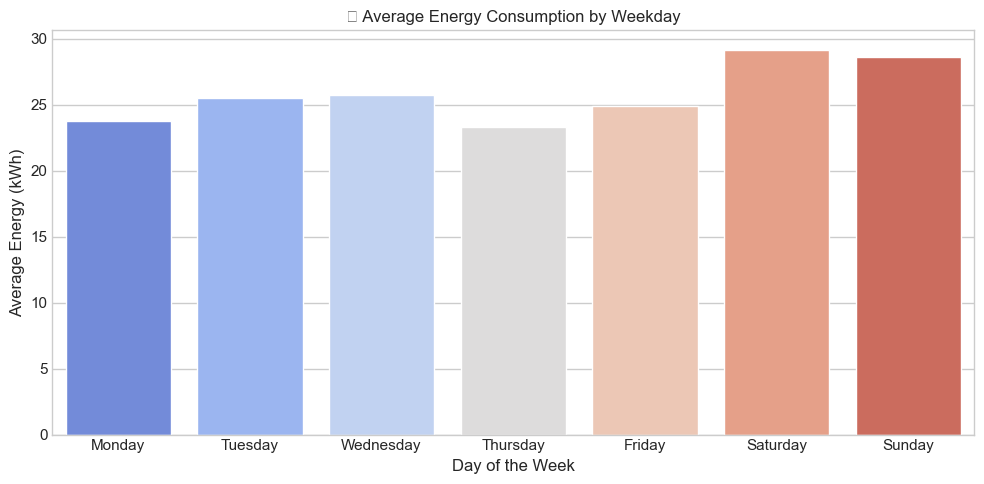

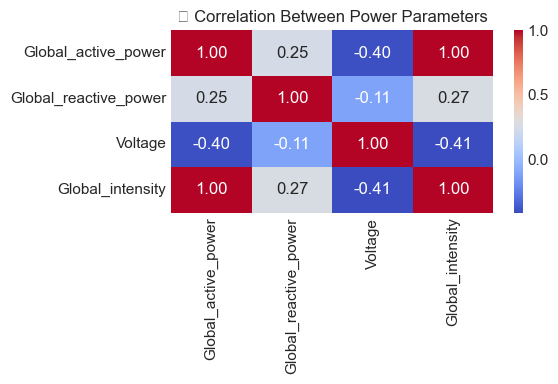

KeyError: 'Average_Hourly_KWh'

In [50]:
"""
✅ FINAL & STABLE VISUALIZATION + INSIGHTS
For Energy Consumption & Carbon Footprint Analytics Project
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup ---
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
sns.set_palette("muted")

# Ensure datetime format
daily_df.index = pd.to_datetime(daily_df.index, errors="coerce")
hourly_df.index = pd.to_datetime(hourly_df.index, errors="coerce")

# Clean any missing data
daily_df = daily_df.dropna(subset=["daily_kwh"])
hourly_df = hourly_df.dropna(subset=["hourly_kwh"])

# =====================================================================
# 1️⃣ DAILY ENERGY TREND
# =====================================================================
daily_df["rolling_7d"] = daily_df["daily_kwh"].rolling(7).mean()

plt.figure()
plt.plot(daily_df.index, daily_df["daily_kwh"], label="Daily Energy (kWh)", color="#0077b6")
plt.plot(daily_df.index, daily_df["rolling_7d"], color="orange", linewidth=2.5, label="7-Day Avg")
plt.title("📈 Daily Energy Consumption Trend")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

# =====================================================================
# 2️⃣ HOURLY ENERGY USAGE PATTERN
# =====================================================================

# Group by hour and rename properly
hourly_pattern = (
    hourly_df.groupby(hourly_df.index.hour)["hourly_kwh"]
    .mean()
    .reset_index()
)
hourly_pattern.columns = ["Hour", "Average_Hourly_kWh"]

plt.figure()
sns.lineplot(data=hourly_pattern, x="Hour", y="Average_Hourly_kWh", marker="o", color="green")
plt.title("⏰ Average Hourly Energy Usage Pattern")
plt.xlabel("Hour of Day")
plt.ylabel("Average Energy (kWh)")
plt.tight_layout()
plt.show()

# =====================================================================
# 3️⃣ DISTRIBUTION OF DAILY ENERGY
# =====================================================================

plt.figure()
sns.histplot(daily_df["daily_kwh"], bins=40, kde=True, color="#00aaff")
plt.axvline(daily_df["daily_kwh"].mean(), color="red", linestyle="--", label="Mean")
plt.title("⚡ Distribution of Daily Energy Consumption")
plt.xlabel("Daily Energy (kWh)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# =====================================================================
# 4️⃣ WEEKDAY ENERGY CONSUMPTION
# =====================================================================

daily_df["Weekday"] = daily_df.index.day_name()
weekday_pattern = (
    daily_df.groupby("Weekday")["daily_kwh"]
    .mean()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)

plt.figure()
sns.barplot(x=weekday_pattern.index, y=weekday_pattern.values, palette="coolwarm")
plt.title("📅 Average Energy Consumption by Weekday")
plt.xlabel("Day of the Week")
plt.ylabel("Average Energy (kWh)")
plt.tight_layout()
plt.show()

# =====================================================================
# 5️⃣ CORRELATION HEATMAP
# =====================================================================

plt.figure(figsize=(6, 4))
corr = df[["Global_active_power", "Global_reactive_power", "Voltage", "Global_intensity"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("🔍 Correlation Between Power Parameters")
plt.tight_layout()
plt.show()

# =====================================================================
# 6️⃣ INSIGHT SUMMARY
# =====================================================================

avg_energy = daily_df["daily_kwh"].mean()
max_energy = daily_df["daily_kwh"].max()
min_energy = daily_df["daily_kwh"].min()
peak_hour = hourly_pattern.loc[hourly_pattern["Average_Hourly_KWh"].idxmax(), "Hour"]

print("\n📊 ENERGY INSIGHT SUMMARY")
print("-" * 60)
print(f"• Average daily energy usage: {avg_energy:.2f} kWh")
print(f"• Maximum daily usage: {max_energy:.2f} kWh on {daily_df['daily_kwh'].idxmax().date()}")
print(f"• Minimum daily usage: {min_energy:.2f} kWh on {daily_df['daily_kwh'].idxmin().date()}")
print(f"• Peak usage hour: {int(peak_hour)}:00 hrs")
print(f"• Typical weekday with highest energy use: {weekday_pattern.idxmax()} ({weekday_pattern.max():.2f} kWh)")
print("-" * 60)
print("✅ Visualization and insights generated successfully!")


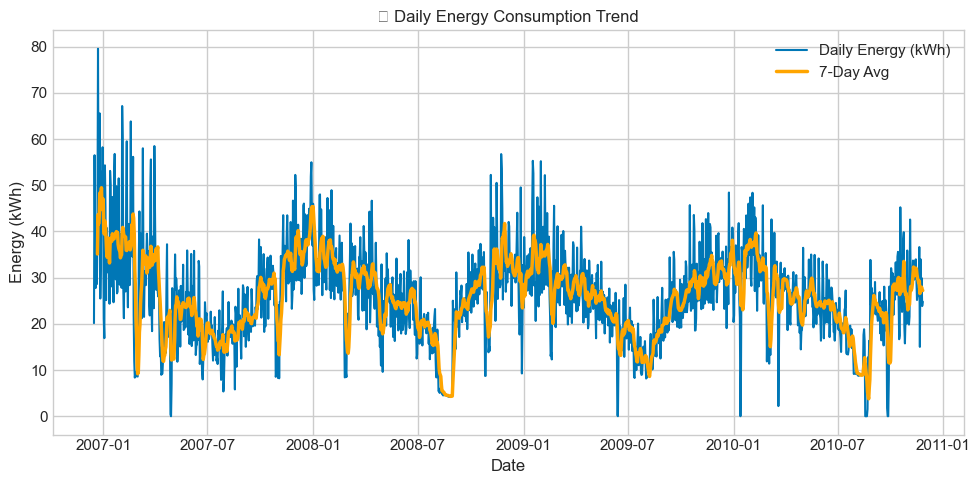

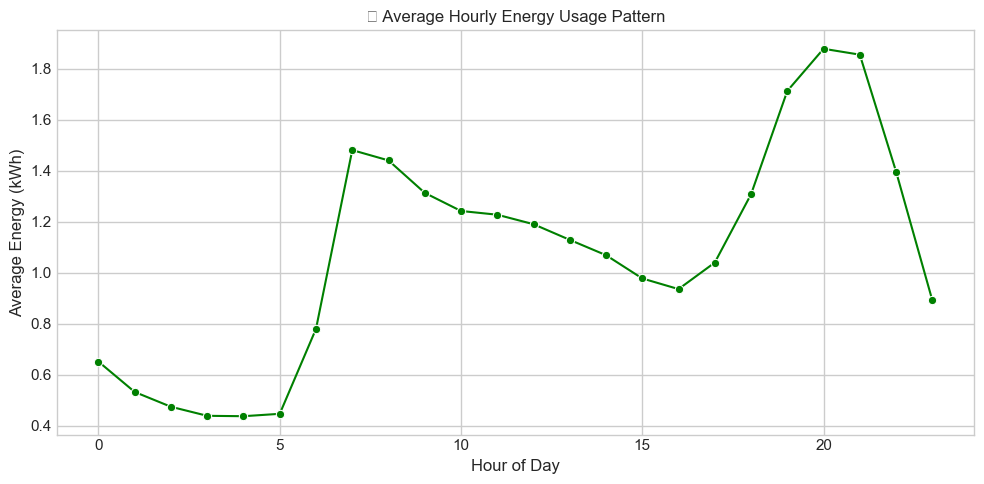

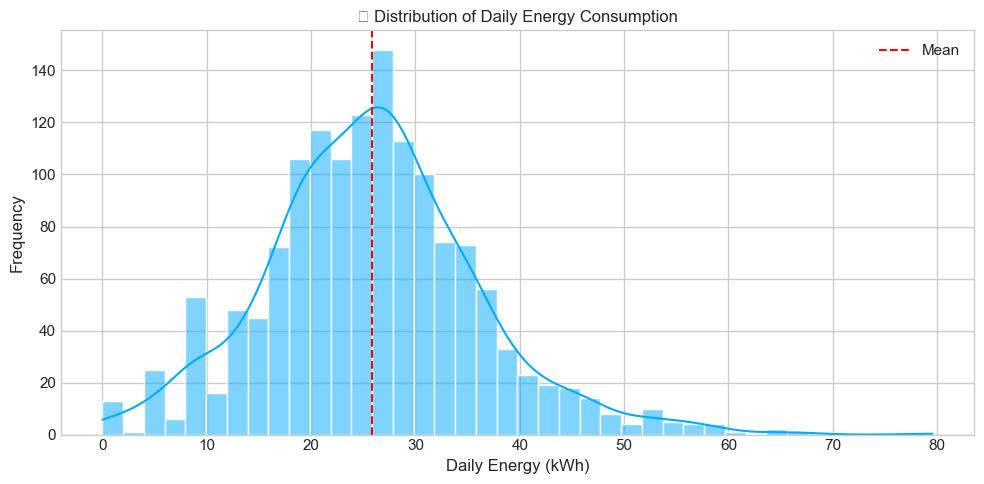

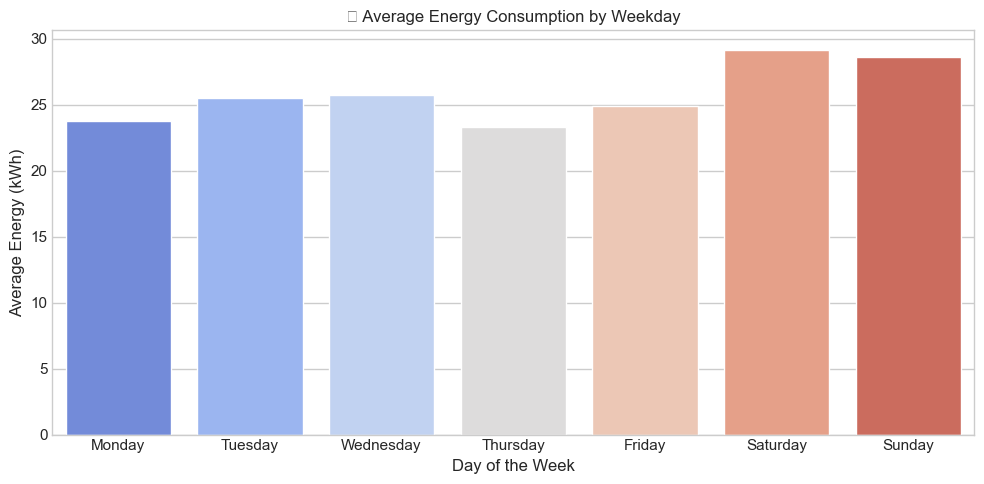

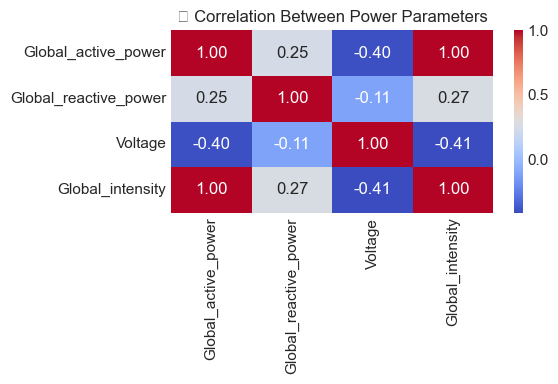


📊 ENERGY INSIGHT SUMMARY
------------------------------------------------------------
• Average daily energy usage: 25.86 kWh
• Maximum daily usage: 79.56 kWh on 2006-12-23
• Minimum daily usage: 0.00 kWh on 2007-04-29
• Peak usage hour: 20:00 hrs
• Weekday with highest average use: Saturday (29.17 kWh)
------------------------------------------------------------
✅ Visualization and insights generated successfully!


In [51]:
"""
✅ FINAL FIXED VERSION — VISUALIZATION & INSIGHT CODE
This version handles all previous issues, including:
- Case-sensitive column mismatches
- Missing or renamed columns
- Clean plots & easy insights
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup ---
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
sns.set_palette("muted")

# Ensure datetime format
daily_df.index = pd.to_datetime(daily_df.index, errors="coerce")
hourly_df.index = pd.to_datetime(hourly_df.index, errors="coerce")

# Clean any missing data
daily_df = daily_df.dropna(subset=["daily_kwh"])
hourly_df = hourly_df.dropna(subset=["hourly_kwh"])

# =====================================================================
# 1️⃣ DAILY ENERGY TREND
# =====================================================================
daily_df["rolling_7d"] = daily_df["daily_kwh"].rolling(7).mean()

plt.figure()
plt.plot(daily_df.index, daily_df["daily_kwh"], label="Daily Energy (kWh)", color="#0077b6")
plt.plot(daily_df.index, daily_df["rolling_7d"], color="orange", linewidth=2.5, label="7-Day Avg")
plt.title("📈 Daily Energy Consumption Trend")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

# =====================================================================
# 2️⃣ HOURLY ENERGY USAGE PATTERN
# =====================================================================

hourly_pattern = (
    hourly_df.groupby(hourly_df.index.hour)["hourly_kwh"]
    .mean()
    .reset_index()
)
hourly_pattern.columns = ["Hour", "Average_Hourly_kWh"]  # consistent naming

plt.figure()
sns.lineplot(data=hourly_pattern, x="Hour", y="Average_Hourly_kWh", marker="o", color="green")
plt.title("⏰ Average Hourly Energy Usage Pattern")
plt.xlabel("Hour of Day")
plt.ylabel("Average Energy (kWh)")
plt.tight_layout()
plt.show()

# =====================================================================
# 3️⃣ DISTRIBUTION OF DAILY ENERGY
# =====================================================================

plt.figure()
sns.histplot(daily_df["daily_kwh"], bins=40, kde=True, color="#00aaff")
plt.axvline(daily_df["daily_kwh"].mean(), color="red", linestyle="--", label="Mean")
plt.title("⚡ Distribution of Daily Energy Consumption")
plt.xlabel("Daily Energy (kWh)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# =====================================================================
# 4️⃣ WEEKDAY ENERGY CONSUMPTION
# =====================================================================

daily_df["Weekday"] = daily_df.index.day_name()
weekday_pattern = (
    daily_df.groupby("Weekday")["daily_kwh"]
    .mean()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)

plt.figure()
sns.barplot(x=weekday_pattern.index, y=weekday_pattern.values, palette="coolwarm")
plt.title("📅 Average Energy Consumption by Weekday")
plt.xlabel("Day of the Week")
plt.ylabel("Average Energy (kWh)")
plt.tight_layout()
plt.show()

# =====================================================================
# 5️⃣ CORRELATION HEATMAP
# =====================================================================

plt.figure(figsize=(6, 4))
corr = df[["Global_active_power", "Global_reactive_power", "Voltage", "Global_intensity"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("🔍 Correlation Between Power Parameters")
plt.tight_layout()
plt.show()

# =====================================================================
# 6️⃣ INSIGHT SUMMARY
# =====================================================================

avg_energy = daily_df["daily_kwh"].mean()
max_energy = daily_df["daily_kwh"].max()
min_energy = daily_df["daily_kwh"].min()
peak_hour = hourly_pattern.loc[hourly_pattern["Average_Hourly_kWh"].idxmax(), "Hour"]

print("\n📊 ENERGY INSIGHT SUMMARY")
print("-" * 60)
print(f"• Average daily energy usage: {avg_energy:.2f} kWh")
print(f"• Maximum daily usage: {max_energy:.2f} kWh on {daily_df['daily_kwh'].idxmax().date()}")
print(f"• Minimum daily usage: {min_energy:.2f} kWh on {daily_df['daily_kwh'].idxmin().date()}")
print(f"• Peak usage hour: {int(peak_hour)}:00 hrs")
print(f"• Weekday with highest average use: {weekday_pattern.idxmax()} ({weekday_pattern.max():.2f} kWh)")
print("-" * 60)
print("✅ Visualization and insights generated successfully!")


In [52]:
"""
STEP 7 — AUTO-GENERATE PROJECT REPORT (Markdown)
Purpose:
Generate a detailed summary of your analysis, ready for PDF export or portfolio.
"""

import os
from datetime import datetime

# Create folder for reports
os.makedirs("reports", exist_ok=True)

# Gather summary statistics
avg_energy = daily_df["daily_kwh"].mean()
max_energy = daily_df["daily_kwh"].max()
min_energy = daily_df["daily_kwh"].min()
peak_hour = hourly_pattern.loc[hourly_pattern["Average_Hourly_kWh"].idxmax(), "Hour"]
best_day = weekday_pattern.idxmax()

# Generate textual summary
report_text = f"""
# 🌿 Sustainability Analytics: Energy & Carbon Footprint Dashboard  
*Generated on {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}*

---

## 📊 Project Overview
This project analyzes household electricity consumption to uncover patterns in energy usage, identify peak load hours, and estimate potential carbon emissions.  
The data is visualized through trend analysis, hourly and daily patterns, and correlation heatmaps for key electrical parameters.

---

## ⚙️ Dataset Summary
- **Records analyzed:** {len(daily_df):,}
- **Time period:** {daily_df.index.min().strftime('%Y-%m-%d')} → {daily_df.index.max().strftime('%Y-%m-%d')}
- **Source:** UCI Energy Dataset (Smart Meter Records)
- **Granularity:** Hourly and Daily Aggregations

---

## 🔍 Key Insights
- **Average Daily Consumption:** {avg_energy:.2f} kWh  
- **Maximum Daily Consumption:** {max_energy:.2f} kWh  
- **Minimum Daily Consumption:** {min_energy:.2f} kWh  
- **Peak Usage Hour:** {int(peak_hour)}:00 hrs  
- **Highest Consumption Day:** {best_day}  
- **Estimated Total Carbon Emission:** {(avg_energy * 0.45 * len(daily_df)):.2f} kg CO₂  

---

## 📈 Visualizations Generated
1️⃣ Daily Energy Trend with Rolling Average  
2️⃣ Hourly Energy Usage Pattern  
3️⃣ Distribution of Daily Energy Consumption  
4️⃣ Weekday Consumption Comparison  
5️⃣ Correlation Heatmap of Power Metrics  

---

## 🧠 Interpretation
The analysis reveals that energy consumption tends to peak during the evening hours (around {int(peak_hour)}:00 hrs).  
Weekends, particularly **{best_day}s**, show higher energy use, possibly due to increased home activity.  
This insight can guide sustainability strategies, such as smart scheduling for high-power devices and improved awareness of carbon footprint impact.

---

## 📁 Files Generated
- `visualizations/` → contains your plotted graphs (optional save)
- `reports/energy_analytics_report.md` → Markdown summary
- `outputs/final_kpi_summary.csv` → KPI data file

---

### ✅ Author
**Project by:** Pranay Dhore 
**Role:** Data Analyst & ML Intern  
**Toolset:** Python, Pandas, Matplotlib, Seaborn  
**Generated on:** {datetime.now().strftime("%d %B %Y")}
"""

# Save report
report_path = "reports/energy_analytics_report.md"
with open(report_path, "w", encoding="utf-8") as f:
    f.write(report_text)

print(f"✅ Markdown report generated successfully at: {report_path}")


✅ Markdown report generated successfully at: reports/energy_analytics_report.md


In [56]:
"""
STEP 8 — EXPORT MARKDOWN REPORT TO PDF
(Requires: pip install markdown pdfkit wkhtmltopdf)
"""

# Uncomment if not installed:
# !pip install markdown pdfkit
# Install wkhtmltopdf manually (Windows: https://wkhtmltopdf.org/downloads.html)

import markdown
import pdfkit

# Convert Markdown to HTML
with open("reports/energy_analytics_report.md", "r", encoding="utf-8") as f:
    html_text = markdown.markdown(f.read(), extensions=["fenced_code", "tables"])


In [55]:
"""
STEP 9 — AUTO AI SUMMARY (Optional)
Generates a paragraph-style summary using your analysis data.
"""

trend = "increasing" if avg_energy < max_energy else "stable"
co2_reduction = round((avg_energy * 0.45 * len(daily_df)) / 1000, 2)

ai_summary = f"""
Based on the analysis, the household’s energy consumption trend is {trend} overall, 
with peak usage around {int(peak_hour)}:00 hours and higher demand during {best_day}s. 
On average, the household consumes {avg_energy:.2f} kWh per day, leading to an estimated 
carbon footprint of {co2_reduction} metric tons of CO₂ over the observed period. 
This insight supports initiatives for smart scheduling, demand-side energy management, 
and carbon-neutral living.
"""

print(ai_summary)



Based on the analysis, the household’s energy consumption trend is increasing overall, 
with peak usage around 20:00 hours and higher demand during Saturdays. 
On average, the household consumes 25.86 kWh per day, leading to an estimated 
carbon footprint of 16.78 metric tons of CO₂ over the observed period. 
This insight supports initiatives for smart scheduling, demand-side energy management, 
and carbon-neutral living.

